In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import pandas as pd

df_original = pd.read_csv('definitivo-oficial(2).csv')
df = pd.read_csv('definitivo-desmembrado.csv')

# o primeiro filtro foi contagem > 1, o que eliminou 1 veículo, ficando 98.
df

,Unnamed: 0,VehId,tile_ID_x,tile_ID_y,day_x,contagem
0,0,12,48208,64033,Saturday,2
1,1,12,48208,64033,Saturday,2
2,2,12,48208,64033,Thursday,3
3,3,12,48208,64033,Thursday,3
4,4,12,48208,64033,Thursday,3
...,...,...,...,...,...,...
3771,3771,603,20542,25818,Saturday,2
3772,3772,603,29339,21306,Saturday,2
3773,3773,603,29339,21306,Saturday,2
3774,3774,603,29733,21307,Saturday,2


In [2]:
def filtrar_trajetos_com_limiar_automatico(df):
    """
    Função que determina automaticamente o limiar adequado
    e filtra o DataFrame de acordo com esse limiar.

    Parâmetros:
    -----------
    df : DataFrame
        DataFrame com os dados de trajetória

    Retorna:
    --------
    DataFrame
        DataFrame filtrado contendo apenas veículos com pelo menos o limiar determinado de registros
    """
    coluna_veiculo = 'VehId'
    coluna_destino = 'tile_ID_y'
    n_estados_hmm = 5

    # Lista de limiares a testar
    limiares = [10, 15, 20, 25, 30, 35, 40, 50]

    # Determinar limiar ideal
    print("Determinando limiar ideal...")
    resultados = []

    for limiar in limiares:
        # Filtrar veículos temporariamente para este limiar
        df_temp = df.groupby(coluna_veiculo).filter(lambda x: len(x) >= limiar)

        if len(df_temp) == 0:
            continue

        # Estatísticas básicas
        n_veiculos = len(df_temp[coluna_veiculo].unique())
        seq_por_veiculo = df_temp.groupby(coluna_veiculo).size()
        media_seq = seq_por_veiculo.mean()

        # Identificar estados únicos
        estados_unicos = len(df_temp[coluna_destino].unique())

        # Critérios de adequação
        adequacao_markov = min(1.0, limiar / (10 * estados_unicos))
        params_hmm = n_estados_hmm**2 + n_estados_hmm * estados_unicos
        adequacao_hmm = min(1.0, limiar / (5 * params_hmm))

        # Pontuação combinada
        pontuacao = (0.5 * adequacao_markov + 0.5 * adequacao_hmm)

        # Penalizar perda de dados
        fator_veiculos = n_veiculos / len(df[coluna_veiculo].unique())
        pontuacao_final = pontuacao * (0.7 + 0.3 * fator_veiculos)

        resultados.append({
            'limiar': limiar,
            'n_veiculos': n_veiculos,
            'pontuacao_final': pontuacao_final
        })

    # Encontrar limiar ideal
    resultados_ordenados = sorted(resultados, key=lambda x: x['pontuacao_final'], reverse=True)
    limiar_ideal = resultados_ordenados[0]['limiar']

    print(f"Limiar ideal determinado: {limiar_ideal}")

    # Aplicar o filtro com o limiar ideal
    df_filtrado = df.groupby(coluna_veiculo).filter(lambda x: len(x) >= limiar_ideal)

    # Mostrar estatísticas
    n_veiculos_original = len(df[coluna_veiculo].unique())
    n_veiculos_filtrado = len(df_filtrado[coluna_veiculo].unique())

    print(f"Veículos retidos: {n_veiculos_filtrado} de {n_veiculos_original} "
          f"({n_veiculos_filtrado/n_veiculos_original*100:.1f}%)")
    print(f"Registros retidos: {len(df_filtrado)} de {len(df)} "
          f"({len(df_filtrado)/len(df)*100:.1f}%)")

    return df_filtrado

In [3]:
df_filtrado = filtrar_trajetos_com_limiar_automatico(df)

Determinando limiar ideal...
Limiar ideal determinado: 50
Veículos retidos: 23 de 98 (23.5%)
Registros retidos: 2129 de 3776 (56.4%)


In [ ]:
# df_filtrado = df.groupby(df['VehId']).filter(lambda x: len(x) >= 30)

In [4]:
df_filtrado['VehId'].nunique()

23

In [5]:
# Ajustar colunas finais
# df = df_expandido[['VehId', 'tile_ID_x', 'tile_ID_y', 'day_x', 'contagem']]
df = df_filtrado.rename(columns={'VehId': 'Veículo', 'tile_ID_x': 'grid_origem', 'tile_ID_y': 'grid_destino',
                        'day_x': 'dia', 'contagem': 'contagem'})

# df = df.loc[df.index.repeat(df['repeat_day_origem'])]

df

,Unnamed: 0,Veículo,grid_origem,grid_destino,dia,contagem
197,197,181,66030,75312,Friday,5
198,198,181,66030,75312,Friday,5
199,199,181,66030,75312,Friday,5
200,200,181,66030,75312,Friday,5
201,201,181,66030,75312,Friday,5
...,...,...,...,...,...,...
3765,3765,597,30422,69926,Wednesday,5
3766,3766,597,30422,69926,Wednesday,5
3767,3767,597,30422,69926,Wednesday,5
3768,3768,597,30422,69926,Wednesday,5


In [6]:
df.to_csv('definitivo-oficial-fase2-limiar50.csv', index=False)

In [7]:
df

,Unnamed: 0,Veículo,grid_origem,grid_destino,dia,contagem
197,197,181,66030,75312,Friday,5
198,198,181,66030,75312,Friday,5
199,199,181,66030,75312,Friday,5
200,200,181,66030,75312,Friday,5
201,201,181,66030,75312,Friday,5
...,...,...,...,...,...,...
3765,3765,597,30422,69926,Wednesday,5
3766,3766,597,30422,69926,Wednesday,5
3767,3767,597,30422,69926,Wednesday,5
3768,3768,597,30422,69926,Wednesday,5


In [8]:
# Operação reversa do index.repeat do Pandas:

# Opção 1: Somar as contagens (se cada linha representa uma unidade)
df_original = df.groupby(['Veículo', 'grid_origem', 'grid_destino', 'dia'])['contagem'].sum().reset_index()

# Opção 2: Pegar apenas valores únicos (se a contagem já está correta mas repetida)
df_original = df.drop_duplicates(subset=['Veículo', 'grid_origem', 'grid_destino', 'dia'])

# Opção 3: Contar o número de ocorrências
df_original = df.groupby(['Veículo', 'grid_origem', 'grid_destino', 'dia']).size().reset_index(name='contagem')

df_original

,Veículo,grid_origem,grid_destino,dia,contagem
0,181,66030,75312,Friday,5
1,181,66030,75312,Saturday,2
2,181,66449,64033,Friday,2
3,181,66449,64033,Wednesday,4
4,181,66449,73732,Thursday,3
...,...,...,...,...,...
628,597,30422,69926,Friday,2
629,597,30422,69926,Monday,3
630,597,30422,69926,Sunday,2
631,597,30422,69926,Thursday,5


In [9]:
df = df_original

Valor máximo geral: 2129
Top 5 valores somados-agrupados:
    Veículo  contagem
18      560       195
13      450       154
12      388       147
4       276       142
19      561       135


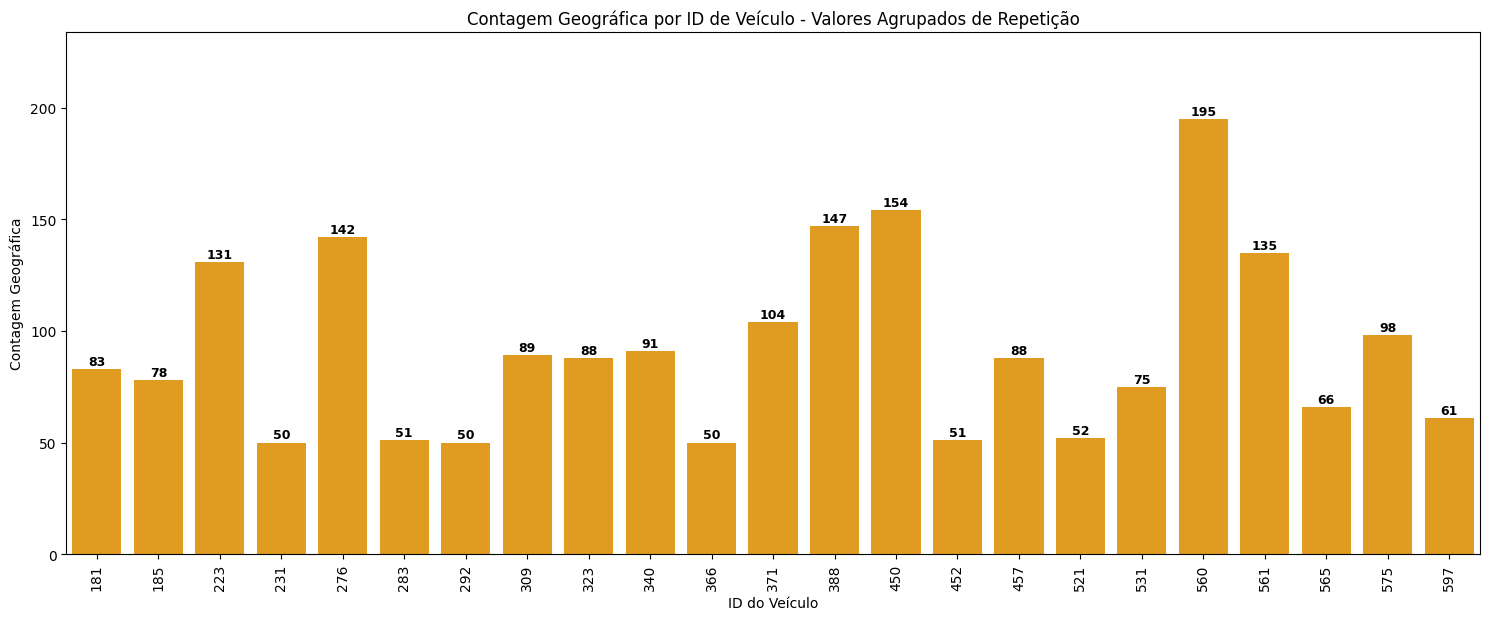

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Primeiro, agregamos os dados para obter o máximo por VehId
df_max = df.groupby('Veículo')['contagem'].sum().reset_index()

# Verificamos os valores máximos
print(f"Valor máximo geral: {df_max['contagem'].sum()}")
print("Top 5 valores somados-agrupados:")
print(df_max.sort_values('contagem', ascending=False).head())

# Configurando o tamanho da figura
plt.figure(figsize=(15, 8))

# Usando seaborn para o gráfico, mas com nossos dados pré-agregados
ax = sns.barplot(x='Veículo', y='contagem', data=df_max, color='orange', errorbar=None)

# Aumentar os limites do eixo y para garantir espaço para os textos
y_max = df_max['contagem'].max()
ax.set_ylim(0, y_max * 1.2)

# Obter as barras do gráfico
bars = ax.patches

# Adicionar os valores sobre as barras
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.5,
            str(int(height)),  # Convertendo para inteiro para remover casas decimais
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Melhorando as etiquetas e título
plt.xlabel('ID do Veículo')
plt.ylabel('Contagem Geográfica')
plt.title('Contagem Geográfica por ID de Veículo - Valores Agrupados de Repetição')

# Ajustando a rotação dos rótulos no eixo x para melhor legibilidade
plt.xticks(rotation=90)

# Ajustando o layout para evitar cortes
plt.tight_layout()

# Ajustando especificamente o espaço inferior para os rótulos
plt.subplots_adjust(bottom=0.3)

# Exibindo o gráfico
plt.show()

In [11]:
df = df[['Veículo','grid_origem','grid_destino','dia','contagem']]

df

,Veículo,grid_origem,grid_destino,dia,contagem
0,181,66030,75312,Friday,5
1,181,66030,75312,Saturday,2
2,181,66449,64033,Friday,2
3,181,66449,64033,Wednesday,4
4,181,66449,73732,Thursday,3
...,...,...,...,...,...
628,597,30422,69926,Friday,2
629,597,30422,69926,Monday,3
630,597,30422,69926,Sunday,2
631,597,30422,69926,Thursday,5


In [12]:
df = df.loc[df.index.repeat(df['contagem'])]

df

,Veículo,grid_origem,grid_destino,dia,contagem
0,181,66030,75312,Friday,5
0,181,66030,75312,Friday,5
0,181,66030,75312,Friday,5
0,181,66030,75312,Friday,5
0,181,66030,75312,Friday,5
...,...,...,...,...,...
632,597,30422,69926,Wednesday,5
632,597,30422,69926,Wednesday,5
632,597,30422,69926,Wednesday,5
632,597,30422,69926,Wednesday,5


In [13]:
import pandas as pd
from IPython.display import display, HTML

def criar_dicionario_dados(df, descricoes):
    """
    Cria um dicionário de dados para um dataframe.

    Parâmetros:
    df (pandas.DataFrame): O dataframe para o qual criar o dicionário
    descricoes (dict): Dicionário com nomes das colunas como chaves e descrições como valores

    Retorna:
    pandas.DataFrame: Um dataframe representando o dicionário de dados
    """
    # Criar listas para armazenar informações
    nomes = []
    tipos = []
    descricoes_lista = []

    # Obter informações de cada coluna
    for coluna in df.columns:
        nomes.append(coluna)
        tipos.append(str(df[coluna].dtype))
        # Verificar se existe descrição para a coluna
        if coluna in descricoes:
            descricoes_lista.append(descricoes[coluna])
        else:
            descricoes_lista.append("")

    # Criar dataframe do dicionário de dados
    dicionario_dados = pd.DataFrame({
        'Nome': nomes,
        'Tipo': tipos,
        'Descrição': descricoes_lista
    })

    # Para controlar margens e formatação adequada
    return dicionario_dados

# Exemplo de uso:
# Supondo que você tenha um dataframe df
# df = pd.DataFrame({'A': [1, 2], 'B': ['x', 'y'], 'C': [1.1, 2.2]})

# Crie um dicionário com as descrições de cada coluna
descricoes = {
    'Veículo': 'Identificador de cada veículo.',
    'grid_origem': 'Campo dos identificadores/rótulos de cada grade de origem (partida).',
    'grid_destino': 'Campo dos identificadores/rótulos de cada grade de destino (chegada).',
    'dia':'Os dias das partidas.',
    'contagem': 'A quantidade desdobrada das repetições, onde cada repetição se desdobra em mais registros de acordo com seu valor.'
}

# Criar e exibir o dicionário de dados
dicionario = criar_dicionario_dados(df, descricoes)

# Para exibir com formatação HTML (melhor para visualização e controle de margens)
def exibir_dicionario_formatado(dicionario):
    return HTML(dicionario.to_html(index=False, classes='table table-striped',
                                   escape=False, justify='left'))

# Exibir o dicionário formatado
display(exibir_dicionario_formatado(dicionario))

Nome,Tipo,Descrição
Veículo,int64,Identificador de cada veículo.
grid_origem,int64,Campo dos identificadores/rótulos de cada grade de origem (partida).
grid_destino,int64,Campo dos identificadores/rótulos de cada grade de destino (chegada).
dia,object,Os dias das partidas.
contagem,int64,"A quantidade desdobrada das repetições, onde cada repetição se desdobra em mais registros de acordo com seu valor."


In [14]:
# Versão mais avançada com controle de formatação
def exibir_dicionario_estilizado(dicionario):
    estilo = """
    <style>
    .dataframe {
        width: 100%;
        border-collapse: collapse;
    }
    .dataframe th, .dataframe td {
        padding: 8px;
        text-align: left;
        border-bottom: 1px solid #ddd;
    }
    .dataframe th {
        background-color: #f2f2f2;
    }
    .dataframe td:nth-child(3) {
        white-space: pre-wrap;
        max-width: 500px;
    }
    </style>
    """
    return HTML(estilo + dicionario.to_html(index=False, classes='dataframe', escape=False))

# Exibir com estilo
display(exibir_dicionario_estilizado(dicionario))

Nome,Tipo,Descrição
Veículo,int64,Identificador de cada veículo.
grid_origem,int64,Campo dos identificadores/rótulos de cada grade de origem (partida).
grid_destino,int64,Campo dos identificadores/rótulos de cada grade de destino (chegada).
dia,object,Os dias das partidas.
contagem,int64,"A quantidade desdobrada das repetições, onde cada repetição se desdobra em mais registros de acordo com seu valor."
